In [60]:
from safetensors.torch import load_file
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

In [62]:
# Defining file paths
config_path = "../TM2025_project/bert_emotion_classifier/config.json"
model_path = "../TM2025_project/bert_emotion_classifier/model.safetensors"
vocab_path = "../TM2025_project/bert_emotion_classifier/vocab.txt"
data_path = "../TM2025_project/data/preprocessed_letters.csv"
output_path = "../TM2025_project/sentiment_predictions_2.csv"
chunk_output_path = "../TM2025_project/chunk_level_predictions.csv"

In [64]:
#path = kagglehub.model_download("omlande/bert-multiclassification-sentiment-analysis/pyTorch/default")
#print("Path to model files:", path)

In [66]:
# Loading model
config = BertConfig.from_json_file(config_path)
state_dict = load_file(model_path)
model = BertForSequenceClassification(config)
model.load_state_dict(state_dict)
model.eval()

# Loading tokenizer
tokenizer = BertTokenizer(
    vocab_file=vocab_path,
    do_lower_case=True,
    unk_token="[UNK]",
    sep_token="[SEP]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    mask_token="[MASK]"
)

# Loading data
df = pd.read_csv(data_path)
text_column = "letter"

In [67]:
# "Chunking"
def chunking_express(text, chunk_size=130):
    words = text.strip().split()
    return [" ".join(words[i:i+chunk_size]) for i in range(0, len(words), chunk_size)]

# Preparing dataset
class ChunkDataset(Dataset):
    def __init__(self, chunk_list, tokenizer, max_len=128):
        self.chunk_list = chunk_list
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.chunk_list)

    def __getitem__(self, idx):
        encodings = self.tokenizer(
            self.chunk_list[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encodings.items()}

# Finding best chunk size
def find_best_chunk_size(min_size=50, max_size=150, step=-10):
    best_chunk_size = None
    min_neutral_count = float('inf')
    
    for chunk_size in range(max_size, min_size - 1, step):
        print(f"Evaluating chunk size: {chunk_size}")
        
        final_preds = []

        for letter in tqdm(df[text_column]):
            chunks = chunking_express(letter, chunk_size=chunk_size)
            dataset = ChunkDataset(chunks, tokenizer)
            dataloader = DataLoader(dataset, batch_size=8)

            all_logits = []
            with torch.no_grad():
                for batch in dataloader:
                    outputs = model(
                        input_ids=batch['input_ids'],
                        attention_mask=batch['attention_mask']
                    )
                    all_logits.append(outputs.logits)

            avg_logits = torch.cat(all_logits, dim=0).max(dim=0).values
            pred_idx = torch.argmax(avg_logits).item()
            final_preds.append(id2label[pred_idx])
        
        # Count neutral predictions
        neutral_count = sum(1 for pred in final_preds if pred.lower() == "neutral")
        print(f"Neutral predictions: {neutral_count}")

        # Check for best
        if neutral_count < min_neutral_count:
            min_neutral_count = neutral_count
            best_chunk_size = chunk_size
    
    print(f"\nBest chunk size: {best_chunk_size} with {min_neutral_count} neutral predictions")
    return best_chunk_size

# Plotting
def plot_emotion_distribution(title, csv_path):
    # Loading CSV
    df = pd.read_csv(csv_path)

    # Getting counts and percentages
    emotion_counts_abs = df['predicted_sentiment'].value_counts()
    emotion_counts_pct = (emotion_counts_abs / len(df)) * 100

    # Plotting the bar graph
    fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')  # Transparent background
    bars = ax.bar(emotion_counts_abs.index, emotion_counts_abs.values, color='orange')

    # Annotating each bar with percentage
    for bar, pct in zip(bars, emotion_counts_pct.values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{pct:.1f}%', 
                ha='center', va='bottom', fontsize=10)

    # Labels and styling
    ax.set_title(title)
    ax.set_ylabel("Number of Letters")
    ax.set_xlabel("Emotion")
    ax.set_xticklabels(emotion_counts_abs.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.set_facecolor('none')  # Transparent axes background

    plt.tight_layout()
    plt.show()

In [70]:
# Setting up label mapping
id2label = {int(k): v for k, v in config.id2label.items()}

# Predictions
final_preds = []
chunk_data = []

In [72]:
#find_best_chunk_size()

In [74]:
# Setting up label mapping
id2label = {int(k): v for k, v in config.id2label.items()}

# Predictions
final_preds = []
chunk_data = []

for letter_idx, letter in tqdm(enumerate(df[text_column]), total=len(df)):
    chunks = chunking_express(letter)
    dataset = ChunkDataset(chunks, tokenizer)
    dataloader = DataLoader(dataset, batch_size=8)
    
    all_logits = []
    for i, chunk in enumerate(chunks):
        pass  # For indexing

    with torch.no_grad():
        chunk_counter = 0
        for batch in dataloader:
            outputs = model(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask']
            )
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            for j in range(logits.size(0)):
                chunk_data.append({
                    "letter_index": letter_idx,
                    "chunk_index": chunk_counter,
                    "chunk_text": chunks[chunk_counter],
                    "predicted_sentiment": id2label[preds[j].item()]
                })
                chunk_counter += 1

            all_logits.append(logits)
    """
    avg_logits = torch.cat(all_logits, dim=0).mean(dim=0)
    pred_idx = torch.argmax(avg_logits).item()
    final_preds.append(id2label[pred_idx])
    """
    #"""
    avg_logits = torch.cat(all_logits, dim=0).max(dim=0).values
    pred_idx = torch.argmax(avg_logits).item()
    final_preds.append(id2label[pred_idx])
    #"""
    """
    probs = [torch.nn.functional.softmax(logits, dim=-1) for logits in all_logits]
    avg_probs = torch.mean(torch.cat(probs, dim=0), dim=0)
    pred_idx = torch.argmax(avg_probs).item()
    final_preds.append(id2label[pred_idx])
    """

100%|████████████████████████████████████████████████████████████████████████████████| 403/403 [01:18<00:00,  5.13it/s]


In [75]:
# Saving final predictions
df["predicted_sentiment"] = final_preds
df.to_csv(output_path, index=False)

# Saving chunk-level predictions
chunk_df = pd.DataFrame(chunk_data)
chunk_df.to_csv(chunk_output_path, index=False)

print("Letter-level and chunk-level predictions saved.")

Letter-level and chunk-level predictions saved.


C:\Users\kevin\AppData\Local\Temp\ipykernel_30376\3235209071.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(emotion_counts_abs.index, rotation=45, ha='right')


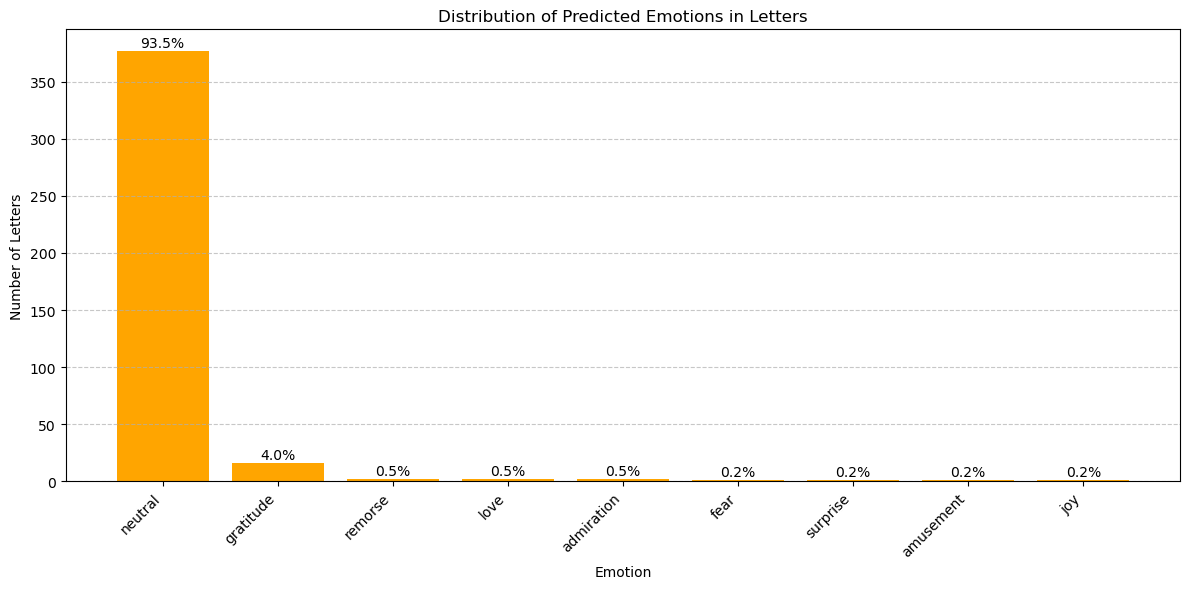

In [76]:
plot_emotion_distribution("Distribution of Predicted Emotions in Letters", output_path)

C:\Users\kevin\AppData\Local\Temp\ipykernel_30376\3235209071.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(emotion_counts_abs.index, rotation=45, ha='right')


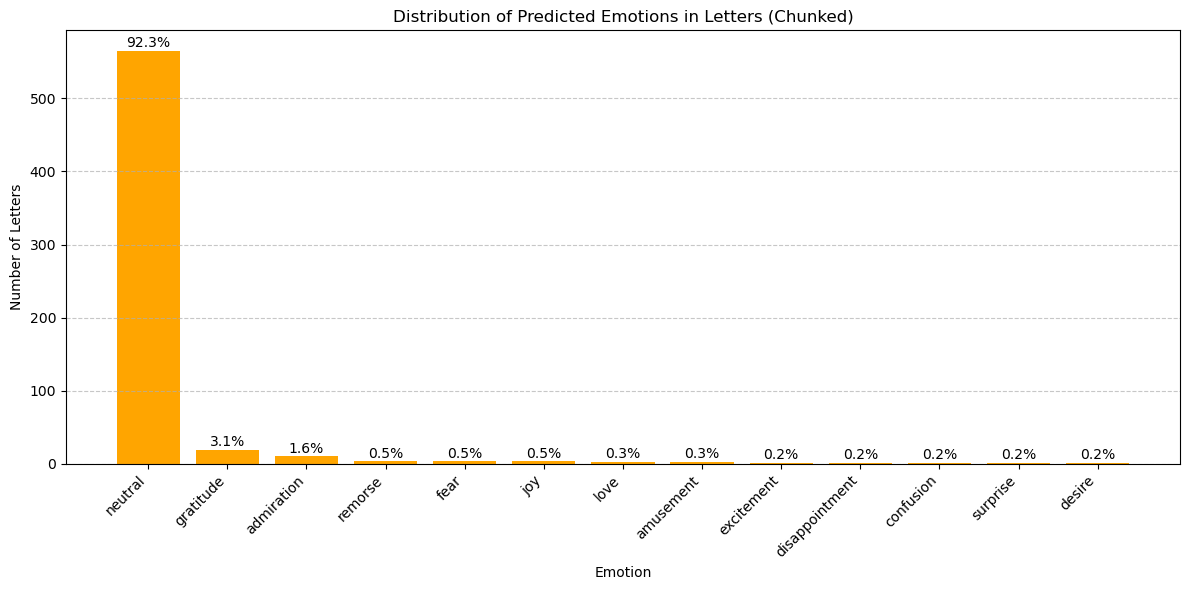

In [77]:
plot_emotion_distribution("Distribution of Predicted Emotions in Letters (Chunked)", chunk_output_path)